In [86]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
#from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import norm
from openml import tasks, flows, runs, datasets, config
import random
from sklearn.pipeline import Pipeline
import pandasql as psql

df = pd.read_csv("train.csv")
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


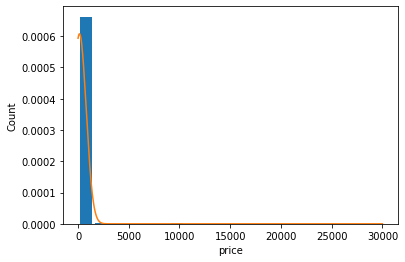

In [87]:
plt.hist(df["TARGET(PRICE_IN_LACS)"], bins=20, rwidth=0.8, density=True)
plt.xlabel('price')
plt.ylabel('Count')

rng = np.arange(df["TARGET(PRICE_IN_LACS)"].min(), df["TARGET(PRICE_IN_LACS)"].max(), 0.1)
plt.plot(rng, norm.pdf(rng,df["TARGET(PRICE_IN_LACS)"].mean(),df["TARGET(PRICE_IN_LACS)"].std()))

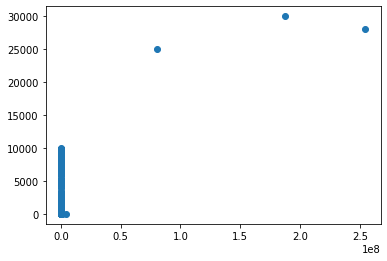

In [88]:
plt.scatter(df["SQUARE_FT"], df["TARGET(PRICE_IN_LACS)"])

In [89]:
df.isna().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [90]:
df.BHK_OR_RK.unique()

array(['BHK', 'RK'], dtype=object)

In [91]:
# working on BHK_OR_RK
df.BHK_OR_RK = df.BHK_OR_RK.apply(lambda x: 1 if x == "BHK" else 0)
df.shape

(29451, 12)

In [92]:
query = "select `address`, count(*) as cnt from df group by `ADDRESS` order by count(*) desc"
res  = psql.sqldf(query)

In [93]:
lst = list(res[res.cnt >= 10]["ADDRESS"])
len(lst)

626

In [94]:
df.ADDRESS = df.ADDRESS.apply(lambda x: x if x in lst else "Other Location")

In [95]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,1,1300.236407,1,1,Other Location,12.969910,77.597960,55.0
1,Dealer,0,0,2,1,1275.000000,1,1,Other Location,12.274538,76.644605,51.0
2,Owner,0,0,2,1,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,1,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,1,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [96]:
# working on address
dummies = pd.get_dummies(df["ADDRESS"])
df = pd.concat([df,dummies], axis="columns")
df = df.drop(["ADDRESS", "Other Location"], axis="columns")
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,...,"Worli,Mumbai","Yelahanka,Bangalore","Yemlur,Bangalore","Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida"
0,Owner,0,0,2,1,1300.236407,1,1,12.969910,77.597960,...,0,0,0,0,0,0,0,0,0,0
1,Dealer,0,0,2,1,1275.000000,1,1,12.274538,76.644605,...,0,0,0,0,0,0,0,0,0,0
2,Owner,0,0,2,1,933.159722,1,1,12.778033,77.632191,...,0,0,0,0,0,0,0,0,0,0
3,Owner,0,1,2,1,929.921143,1,1,28.642300,77.344500,...,0,0,0,0,0,0,0,0,0,0
4,Dealer,1,0,2,1,999.009247,0,1,22.592200,88.484911,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df.POSTED_BY.unique()

array(['Owner', 'Dealer', 'Builder'], dtype=object)

In [98]:
# working on posted_by
dummies = pd.get_dummies(df.POSTED_BY)
df = pd.concat([df,dummies], axis="columns")
df = df.drop(["POSTED_BY", "Builder"], axis="columns")
df.shape

(29451, 638)

In [99]:
# removing outliers
df["areaPerRoom"] = df["SQUARE_FT"] / df["BHK_NO."]
df.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),...,"Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida",Dealer,Owner,areaPerRoom
0,0,0,2,1,1300.236407,1,1,12.969910,77.597960,55.0,...,0,0,0,0,0,0,0,0,1,650.118204
1,0,0,2,1,1275.000000,1,1,12.274538,76.644605,51.0,...,0,0,0,0,0,0,0,1,0,637.500000
2,0,0,2,1,933.159722,1,1,12.778033,77.632191,43.0,...,0,0,0,0,0,0,0,0,1,466.579861
3,0,1,2,1,929.921143,1,1,28.642300,77.344500,62.5,...,0,0,0,0,0,0,0,0,1,464.960571
4,1,0,2,1,999.009247,0,1,22.592200,88.484911,60.5,...,0,0,0,0,0,0,0,1,0,499.504623


In [100]:
Q1 = df.areaPerRoom.quantile(0.25)
Q3 = df.areaPerRoom.quantile(0.75)
IQR = Q3 - Q1
lower_lmt = Q1 - 1.5 * IQR
upper_lmt = Q3 + 1.5 * IQR
df = df[(df.areaPerRoom > lower_lmt) & (df.areaPerRoom < upper_lmt)]

In [101]:
df.shape

(28267, 639)

In [102]:
df = df.drop(["areaPerRoom"], axis="columns")

In [103]:
df["pricePerUnitArea"] = df["TARGET(PRICE_IN_LACS)"] / df["SQUARE_FT"]
df.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),...,"Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida",Dealer,Owner,pricePerUnitArea
0,0,0,2,1,1300.236407,1,1,12.969910,77.597960,55.0,...,0,0,0,0,0,0,0,0,1,0.04230
1,0,0,2,1,1275.000000,1,1,12.274538,76.644605,51.0,...,0,0,0,0,0,0,0,1,0,0.04000
2,0,0,2,1,933.159722,1,1,12.778033,77.632191,43.0,...,0,0,0,0,0,0,0,0,1,0.04608
3,0,1,2,1,929.921143,1,1,28.642300,77.344500,62.5,...,0,0,0,0,0,0,0,0,1,0.06721
4,1,0,2,1,999.009247,0,1,22.592200,88.484911,60.5,...,0,0,0,0,0,0,0,1,0,0.06056


In [104]:
maxPer, minPer = df["pricePerUnitArea"].quantile([0.9, 0.1])
df = df[(df["pricePerUnitArea"] < maxPer) & (df["pricePerUnitArea"] > minPer)]

In [105]:
df = df.drop(["pricePerUnitArea"], axis="columns")
df.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),...,"Yemlur,Bangalore","Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida",Dealer,Owner
0,0,0,2,1,1300.236407,1,1,12.969910,77.597960,55.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,2,1,1275.000000,1,1,12.274538,76.644605,51.0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,2,1,933.159722,1,1,12.778033,77.632191,43.0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,2,1,929.921143,1,1,28.642300,77.344500,62.5,...,0,0,0,0,0,0,0,0,0,1
4,1,0,2,1,999.009247,0,1,22.592200,88.484911,60.5,...,0,0,0,0,0,0,0,0,1,0


In [106]:
X = df.drop(["TARGET(PRICE_IN_LACS)"], axis="columns")
y = df["TARGET(PRICE_IN_LACS)"]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [107]:
# lambdas=np.linspace(1,10,100)

# model_params = {
#     'linearRegression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'Lasso': {
#         'model': Lasso(),
#         'params': {
#             'alpha':lambdas,
#         }
#     },
#     'Ridge': {
#         'model': Ridge(),
#         'params': {
#             'alpha':lambdas,
#         }
#     },
# }

# score = []
# best_estimators = {}

# for model_name, mp in model_params.items():
#     clf =  RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=3,scoring='accuracy')
#     clf.fit(X, y)
#     score.append({
#         'model': model_name,
#         'best_score': clf.best_score_,
#         'best_params': clf.best_params_
#     })
#     best_estimators[model_name] = clf.best_estimator_
    
# df = pd.DataFrame(score,columns=['model','best_score','best_params'])
# df

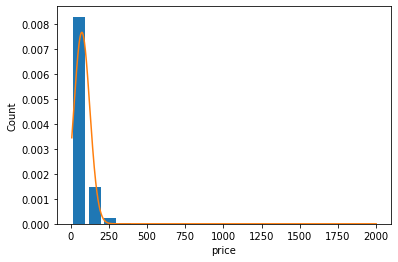

In [108]:
plt.hist(df["TARGET(PRICE_IN_LACS)"], bins=20, rwidth=0.8, density=True)
plt.xlabel('price')
plt.ylabel('Count')

rng = np.arange(df["TARGET(PRICE_IN_LACS)"].min(), df["TARGET(PRICE_IN_LACS)"].max(), 0.1)
plt.plot(rng, norm.pdf(rng,df["TARGET(PRICE_IN_LACS)"].mean(),df["TARGET(PRICE_IN_LACS)"].std()))

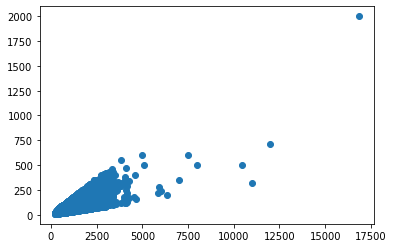

In [109]:
plt.scatter(df["SQUARE_FT"], df["TARGET(PRICE_IN_LACS)"])

In [110]:
test = pd.read_csv("test.csv")
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171340,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.000000,0,0,"Panvel,Lalitpur",18.966114,73.148278
2,Dealer,0,0,2,BHK,1257.096513,1,1,"New Town,Kolkata",22.592200,88.484911
3,Dealer,0,0,3,BHK,1400.329489,1,1,"Kalwar Road,Jaipur",26.988300,75.584600
4,Owner,0,0,1,BHK,430.477830,1,1,"Mai Mandir,Nadiad",22.700000,72.870000


In [111]:
test.BHK_OR_RK = df.BHK_OR_RK.apply(lambda x: 1 if x == "BHK" else 0)
test.shape

(68720, 11)

In [112]:
test.ADDRESS = test.ADDRESS.apply(lambda x: x if x in lst else "Other Location")

In [113]:
dummies = pd.get_dummies(test["ADDRESS"])
test = pd.concat([test,dummies], axis="columns")
test = test.drop(["ADDRESS", "Other Location"], axis="columns")
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,...,"Worli,Mumbai","Yelahanka,Bangalore","Yemlur,Bangalore","Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida"
0,Owner,0,0,1,0.0,545.171340,1,1,21.262000,73.047700,...,0,0,0,0,0,0,0,0,0,0
1,Dealer,1,1,2,0.0,800.000000,0,0,18.966114,73.148278,...,0,0,0,0,0,0,0,0,0,0
2,Dealer,0,0,2,0.0,1257.096513,1,1,22.592200,88.484911,...,0,0,0,0,0,0,0,0,0,0
3,Dealer,0,0,3,0.0,1400.329489,1,1,26.988300,75.584600,...,0,0,0,0,0,0,0,0,0,0
4,Owner,0,0,1,0.0,430.477830,1,1,22.700000,72.870000,...,0,0,0,0,0,0,0,0,0,0


In [114]:
dummies = pd.get_dummies(test.POSTED_BY)
test = pd.concat([test,dummies], axis="columns")
test = test.drop(["POSTED_BY", "Builder"], axis="columns")
test.shape

(68720, 637)

In [115]:
test.BHK_OR_RK = test.BHK_OR_RK.fillna(0)

In [116]:
test.isna().sum()

UNDER_CONSTRUCTION        0
RERA                      0
BHK_NO.                   0
BHK_OR_RK                 0
SQUARE_FT                 0
                         ..
kavesar,Lalitpur          0
kavesar,Mumbai            0
sector-121 Noida,Noida    0
Dealer                    0
Owner                     0
Length: 637, dtype: int64

In [117]:
result = {}

model = LinearRegression()
model.fit(X,y)
result["TARGET(PRICE_IN_LACS)"] = model.predict(test)

In [118]:
df = pd.DataFrame(result,columns=['TARGET(PRICE_IN_LACS)',])

In [119]:
df.head()

,TARGET(PRICE_IN_LACS)
0,28.010230
1,69.420261
2,74.243783
3,73.741944
4,18.642543


In [120]:
df.to_csv("submission.csv", index=False)

In [121]:
lst = list(test.columns)

In [122]:
for i in lst:
    print(i)

UNDER_CONSTRUCTION
RERA
BHK_NO.
BHK_OR_RK
SQUARE_FT
READY_TO_MOVE
RESALE
LONGITUDE
LATITUDE
6th Phase JP Nagar,Bangalore
7th Phase JP Nagar,Bangalore
8th Phase JP Nagar,Bangalore
Action Area I,Kolkata
Action Area II,Kolkata
Action area 1A,Kolkata
Adajan,Surat
Adityapur,Jamshedpur
Aerocity,Mohali
Ahinsa Khand 1,Ghaziabad
Ahinsa Khand 2,Ghaziabad
Airport,Kolkata
Ajmer Road,Jaipur
Akota,Vadodara
Akshaya Nagar,Bangalore
Alipore,Kolkata
Alkapuri,Vadodara
Althan,Surat
Alwar Bhiwadi Road,Bhiwadi
Alwar Bypass Road,Bhiwadi
Amar Shaheed Path,Lucknow
Ambalipura,Bangalore
Ambattur,Chennai
Amroli,Surat
Amruthahalli,Bangalore
Ananth Nagar,Bangalore
Andheri (East),Lalitpur
Andheri (East),Maharashtra
Andheri (East),Mumbai
Andheri (West),Lalitpur
Andheri (West),Maharashtra
Andheri (West),Mumbai
Anekal,Bangalore
Ankleshwar,Bharuch
Ankur Vihar,Ghaziabad
Atladra,Vadodara
Attibele,Bangalore
Aundh,Pune
Avadi,Chennai
BTM 2nd Stage,Bangalore
Badlapur (East),Lalitpur
Baguihati,Kolkata
Balagere,Bangalore
Balewa

In [123]:
file = pd.read_csv("my_file.csv")
file.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,"6th Phase JP Nagar,Bangalore",...,"Yemlur,Bangalore","Yeshwanthpur,Bangalore","Zingabai Takli,Nagpur","Zirakpur,Chandigarh","Zirakpur,Mohali","kavesar,Lalitpur","kavesar,Mumbai","sector-121 Noida,Noida",Dealer,Owner


In [124]:
def predictPrice(postedBy, underConstruction, rera, bhk, bhk_or_rk, sqrtFt, readyToMove, resale, longitude, latitude, address):
    x = np.zeros(len(file.columns))

    # filling data
    x[0] = underConstruction
    x[1] = rera
    x[2] = bhk
    x[3] = bhk_or_rk
    x[4] = sqrtFt
    x[5] = readyToMove
    x[6] = resale
    x[7] = longitude
    x[8] = latitude

    try:
        x[df.columns.get_loc(postedBy)] = 1
    except:
        pass
    
    try:
        x[df.columns.get_loc(address)] = 1
    except:
        pass

    res = model.predict([x])[0]

    if res < 0:
        res = "Such Kind Of House Are Not Available"

    return res

In [125]:
postedBy = "Dealer"
underConstruction = 0
rera = 1
bhk = 4
bhk_or_rk = 10
sqrtFt = 11562
readyToMove = 1
resale = 0
longitude = 13.16 # longitude between -180 and 180. 
latitude = 56.16 # latitude must be a number between -90 and 90 
address = "Kharghar,Lalitpur"

predictPrice(postedBy, underConstruction, rera, bhk, bhk_or_rk, sqrtFt, readyToMove, resale, longitude, latitude, address)

778.0574442746297

In [126]:
joblib.dump(model, "model.pkl")

['model.pkl']

In [127]:
model.intercept_

10.818415685980334

In [128]:
model.coef_

array([-9.55269701e-01,  3.61609952e+00, -4.45721616e+00, -8.03453446e+00,
        7.56317467e-02,  9.55269719e-01, -6.55177634e+00, -4.97612712e-01,
       -1.25779981e-01,  9.23591301e+00,  2.39492520e+01, -8.36253781e+00,
       -9.38294471e+00, -1.13855327e+01, -1.20087098e+01, -2.44843069e+01,
       -2.69684824e+01, -3.71147198e+01,  9.14819930e+00, -2.19427219e+01,
       -2.03359312e+01, -3.17172244e+01, -2.32587089e+01, -8.62228242e+00,
        1.15947554e+02, -2.82172772e+01, -4.21391090e+01, -2.11919419e+01,
       -2.01351116e+01, -1.97443804e+01,  8.64372908e+00, -6.03060679e+00,
       -1.94257219e+01, -7.52411920e+00, -2.50821090e+01,  5.94598055e+01,
        7.46180485e+01,  8.82737705e+01, -5.25840661e+10, -1.27948598e+10,
        3.17872019e+10, -6.28855050e+00, -4.95023981e+10, -8.96647185e-01,
       -2.69250347e+01, -1.31409300e+01,  4.25672533e+01, -1.28344911e+01,
        2.46150317e+01, -1.51277426e+01, -1.18612878e+01,  5.78778694e+00,
        1.40860602e+01,  

In [130]:
import json
obj = json.dumps({"address": lst})

with open("address.json", "w") as outfile:
    outfile.write(obj)